# VAE Analysis: Latent Space Exploration

This notebook analyzes a trained VAE model for DESI sky spectra. It explores:
- Latent space structure and distributions
- Reconstruction quality across sky conditions
- Correlations between latent dimensions and physical parameters
- Latent space interpolation

**Note**: This notebook assumes you have a trained VAE model. See `04A_vae_training.ipynb` for training instructions.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import jax
import jax.numpy as jnp
import jax.random as jr

# Import desisky components
from desisky.data import SkySpecVAC
from desisky.models.vae import make_SkyVAE
from desisky.io import load_builtin

# For latent space analysis
from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA

## Load Trained VAE Model

Load the pre-trained VAE model from the desisky package.

In [2]:
# Load the pre-trained VAE model
vae, meta = load_builtin("vae")

print("✓ VAE model loaded successfully!")
print(f"\nModel Architecture:")
print(f"  Input channels: {meta['arch']['in_channels']}")
print(f"  Latent dimension: {meta['arch']['latent_dim']}")

✓ VAE model loaded successfully!

Model Architecture:
  Input channels: 7781
  Latent dimension: 8


## Load Sky Spectra Data

In [3]:
# Load data
vac = SkySpecVAC(version='v1.0', download=True)
wavelength, flux, metadata = vac.load()

print(f"Loaded {flux.shape[0]:,} sky spectra")
print(f"Wavelength range: {wavelength.min():.1f} - {wavelength.max():.1f} Å")
print(f"Spectrum shape: {flux.shape}")

Loaded 9,176 sky spectra
Wavelength range: 3600.0 - 9824.0 Å
Spectrum shape: (9176, 7781)


## Encode Data and Reconstruct

In [4]:
# Encode all spectra to latent space
mean, logvar = jax.vmap(vae.encode)(flux)

# Sample from latent space
latents = vae.sample(mean, logvar, jr.PRNGKey(42))

# Decode to get reconstructions
decoded = jax.vmap(vae.decode)(latents)

print(f"Latent representations: {latents.shape}")
print(f"Reconstructed spectra: {decoded.shape}")
print(f"\nLatent space statistics:")
print(f"  Mean: {latents.mean(axis=0)}")
print(f"  Std: {latents.std(axis=0)}")

Latent representations: (9176, 8)
Reconstructed spectra: (9176, 7781)

Latent space statistics:
  Mean: [-3.1512194  5.7624016  9.630822   4.651498  -5.3500156 -5.5301733
  4.8108945 -1.7810969]
  Std: [3.8888872 5.1877317 2.916688  4.1511884 4.399737  2.5577123 2.5732975
 5.0770054]


## Classify Sky Conditions

Classify each observation as 'dark', 'moon', 'twilight', or 'other' based on observational parameters.

In [5]:
def classify_sky(meta):
    """
    Classify sky conditions based on metadata.
    
    Parameters
    ----------
    meta : DataFrame
        Metadata with columns: SUNALT, MOONALT, MOONFRAC, MOONSEP, SUNSEP
    
    Returns
    -------
    conditions : array of str
        Sky condition for each observation
    """
    conditions = []
    for i in range(len(meta)):
        sunalt = meta.iloc[i]['SUNALT']
        moonalt = meta.iloc[i]['MOONALT']
        moonfrac = meta.iloc[i]['MOONFRAC']
        moonsep = meta.iloc[i]['MOONSEP']
        sunsep = meta.iloc[i]['SUNSEP']

        if (sunalt > -20) and (moonalt <= -5) and (sunsep <= 110):
            conditions.append("twilight")
        elif (moonalt > 5) and (moonfrac > 0.5) and (moonsep <= 90) and (sunalt < -20):
            conditions.append("moon")
        elif (moonalt < -5) and (sunalt < -20):
            conditions.append("dark")
        else:
            conditions.append("other")
    return np.array(conditions)

# Classify sky conditions
sky_conditions = classify_sky(metadata)

# Print distribution
unique, counts = np.unique(sky_conditions, return_counts=True)
print("Sky condition distribution:")
for cond, count in zip(unique, counts):
    print(f"  {cond}: {count} ({count/len(sky_conditions)*100:.1f}%)")

Sky condition distribution:
  dark: 4177 (45.5%)
  moon: 2290 (25.0%)
  other: 2373 (25.9%)
  twilight: 336 (3.7%)


## Visualization 1: Example Reconstruction

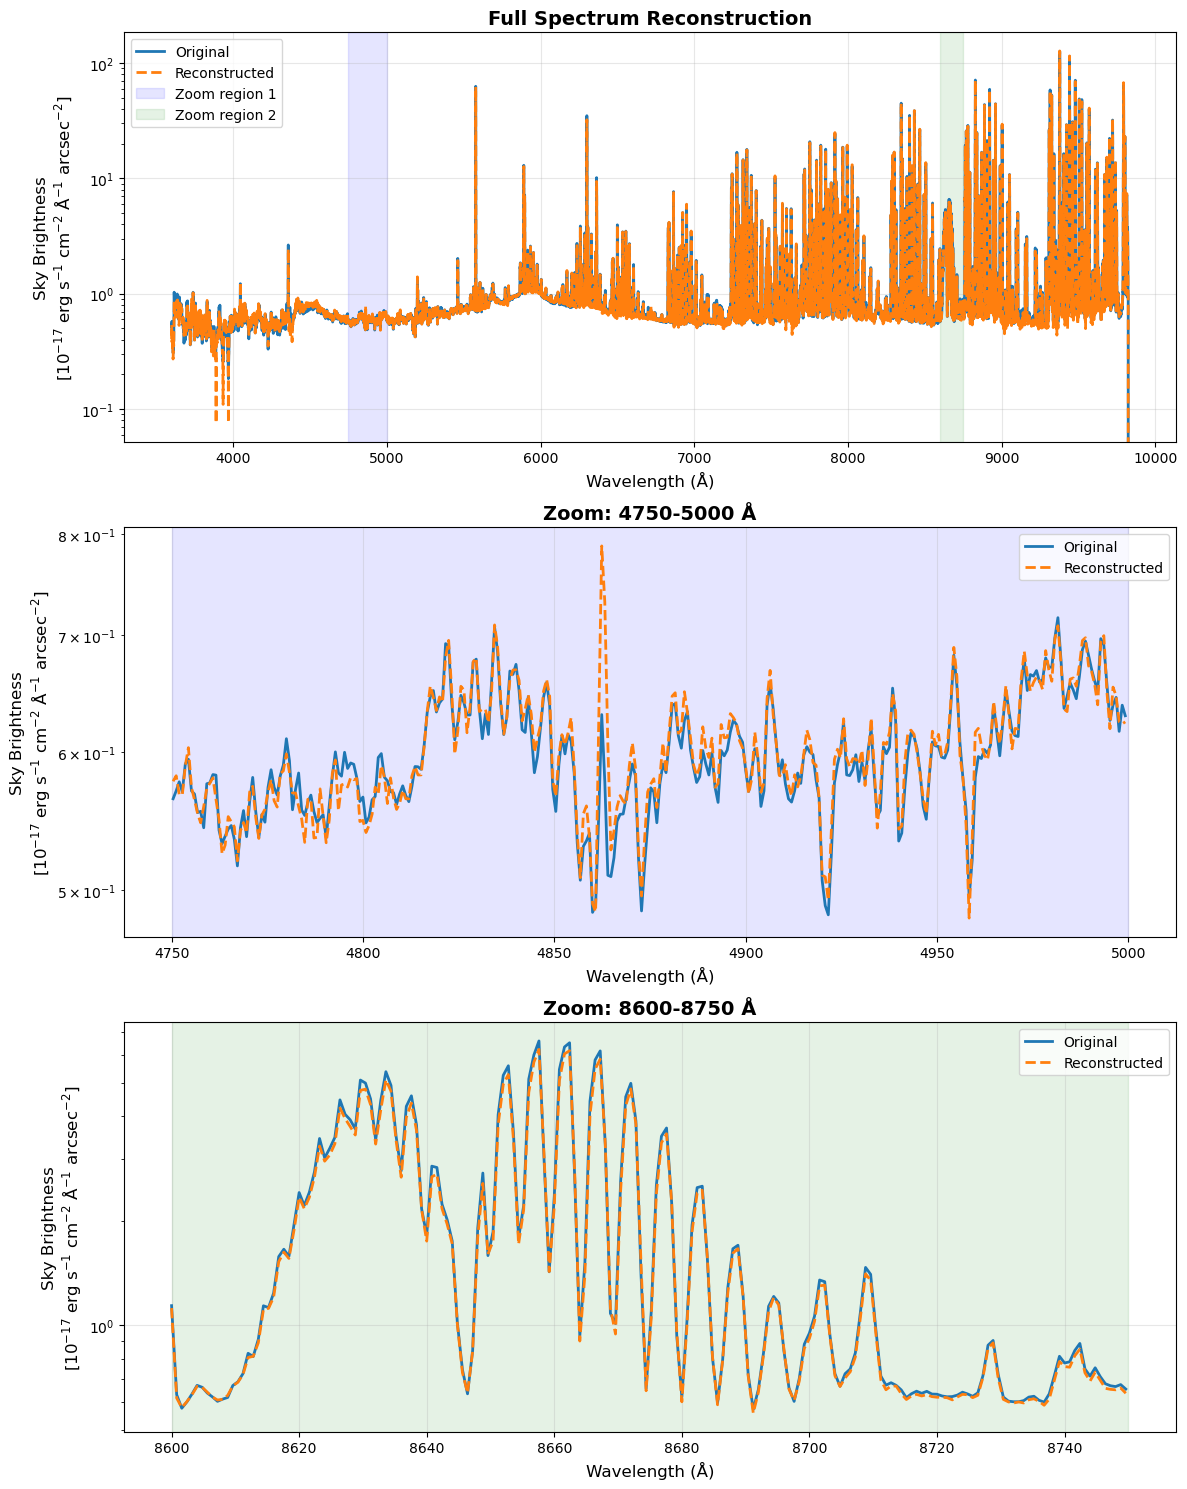

In [6]:
# Plot example reconstruction with zoom regions
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

# Full spectrum
axes[0].plot(wavelength, flux[0], label='Original', linewidth=2)
axes[0].plot(wavelength, decoded[0], label='Reconstructed', linewidth=2, linestyle='--')
axes[0].axvspan(4750, 5000, color='blue', alpha=0.1, label='Zoom region 1')
axes[0].axvspan(8600, 8750, color='green', alpha=0.1, label='Zoom region 2')
axes[0].set_yscale('log')
axes[0].set_xlabel('Wavelength (Å)', fontsize=12)
axes[0].set_ylabel('Sky Brightness\n[$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$ arcsec$^{-2}$]', fontsize=12)
axes[0].set_title('Full Spectrum Reconstruction', fontsize=14, fontweight='bold')
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles[:2] + handles[-2:], labels[:2] + labels[-2:])
axes[0].grid(alpha=0.3)

# Zoom region 1: 4750-5000 Å
i0 = np.searchsorted(wavelength, 4750)
i1 = np.searchsorted(wavelength, 5000)
axes[1].plot(wavelength[i0:i1], flux[0,i0:i1], label='Original', linewidth=2)
axes[1].plot(wavelength[i0:i1], decoded[0,i0:i1], label='Reconstructed', linewidth=2, linestyle='--')
axes[1].axvspan(4750, 5000, color='blue', alpha=0.1)
axes[1].set_yscale('log')
axes[1].set_xlabel('Wavelength (Å)', fontsize=12)
axes[1].set_ylabel('Sky Brightness\n[$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$ arcsec$^{-2}$]', fontsize=12)
axes[1].set_title('Zoom: 4750-5000 Å', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Zoom region 2: 8600-8750 Å
i0 = np.searchsorted(wavelength, 8600)
i1 = np.searchsorted(wavelength, 8750)
axes[2].plot(wavelength[i0:i1], flux[0,i0:i1], label='Original', linewidth=2)
axes[2].plot(wavelength[i0:i1], decoded[0,i0:i1], label='Reconstructed', linewidth=2, linestyle='--')
axes[2].axvspan(8600, 8750, color='green', alpha=0.1)
axes[2].set_yscale('log')
axes[2].set_xlabel('Wavelength (Å)', fontsize=12)
axes[2].set_ylabel('Sky Brightness\n[$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$ arcsec$^{-2}$]', fontsize=12)
axes[2].set_title('Zoom: 8600-8750 Å', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Visualization 2: Corner Plot (Latent Space Distribution)

Visualize the distribution of the learned latent space, colored by sky condition.

/tmp/ipykernel_58831/396333052.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.3)


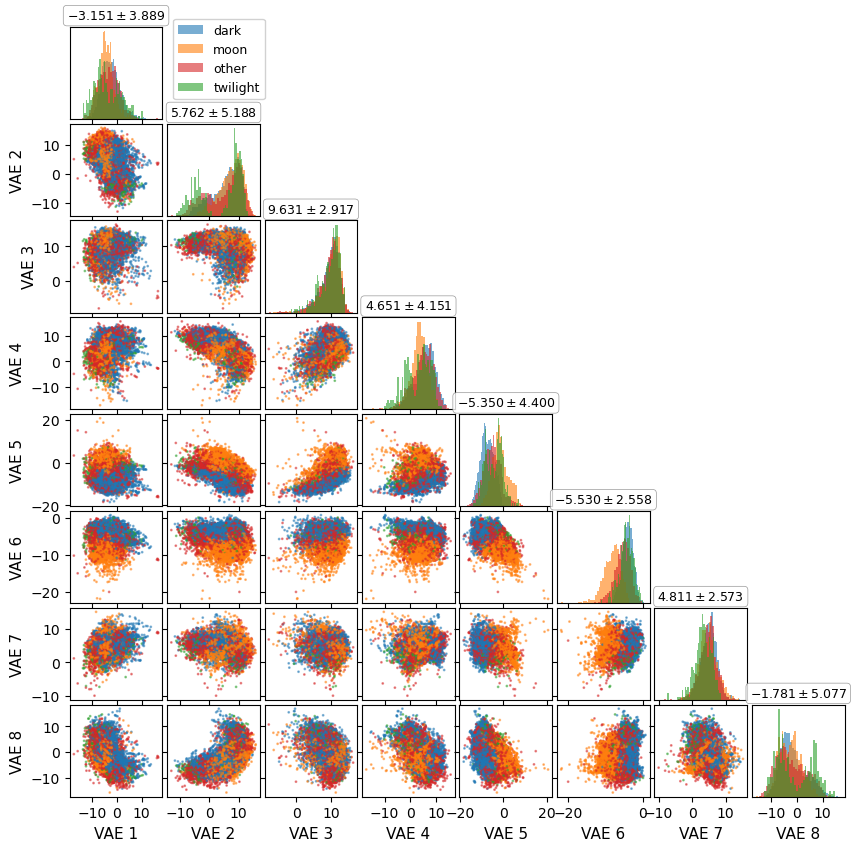

In [7]:
def corner_plot(samples, labels=None, bins=40, figsize=10, max_dims=None,
                plot_type='contour', show_stats=True, show_lines=True, 
                colors=None, point_kwargs=None):
    """
    Corner plot (lower triangle + 1D marginals on the diagonal).
    
    See inline comments for full parameter documentation.
    """
    samples = np.asarray(samples)
    N, D = samples.shape

    if max_dims is not None and max_dims < D:
        D = max_dims
        samples = samples[:, :D]

    if labels is None:
        labels = [f"VAE {i+1}" for i in range(D)]
    else:
        if len(labels) < D:
            labels = list(labels) + [f"VAE {i+1}" for i in range(len(labels), D)]
        else:
            labels = list(labels[:D])

    means = samples.mean(axis=0)
    stds = samples.std(axis=0, ddof=1)

    # Handle colors
    color_map = None
    categorical_colors = None
    unique_categories = None
    if colors is not None:
        colors = np.asarray(colors)
        if colors.dtype.kind in ['U', 'S', 'O']:
            unique_categories = np.unique(colors)
            sky_color_scheme = {
                'dark': '#1f77b4',
                'moon': '#ff7f0e',
                'twilight': '#2ca02c',
                'other': '#d62728'
            }
            categorical_colors = [sky_color_scheme.get(cat, '#7f7f7f') for cat in colors]
            color_map = {cat: sky_color_scheme.get(cat, '#7f7f7f') for cat in unique_categories}

    fig, axes = plt.subplots(D, D, figsize=(figsize, figsize),
                             gridspec_kw={'hspace': 0.05, 'wspace': 0.05})

    if point_kwargs is None:
        point_kwargs = {'s': 1, 'alpha': 0.5, 'rasterized': True}

    legend_handles = []

    for i in range(D):
        for j in range(D):
            ax = axes[i, j]

            if i == j:
                # 1D marginal
                if categorical_colors is not None:
                    for cat in unique_categories:
                        mask = colors == cat
                        h = ax.hist(samples[mask, i], bins=bins, density=True, 
                               alpha=0.6, color=color_map[cat], label=cat)
                        if i == 0:
                            legend_handles.append(plt.Rectangle((0,0),1,1, fc=color_map[cat], alpha=0.6))
                else:
                    ax.hist(samples[:, i], bins=bins, density=True, alpha=0.7, color='steelblue')

                if show_lines:
                    ax.axvline(means[i], color='red', linestyle='-', linewidth=1.5)
                    ax.axvline(means[i] - stds[i], color='red', linestyle='--', linewidth=1)
                    ax.axvline(means[i] + stds[i], color='red', linestyle='--', linewidth=1)

                if show_stats:
                    stats_text = f'${means[i]:.3f} \\pm {stds[i]:.3f}$'
                    ax.text(0.5, 1.05, stats_text, transform=ax.transAxes, ha='center', va='bottom', fontsize=9,
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray', linewidth=0.5))

                if i == D - 1:
                    ax.set_xlabel(labels[i], fontsize=11)
                else:
                    ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.tick_params(axis='y', which='both', left=False)

            elif i > j:
                # Lower triangle: 2D density
                x = samples[:, j]
                y = samples[:, i]

                if plot_type == 'contour':
                    if categorical_colors is not None:
                        for cat in unique_categories:
                            mask = colors == cat
                            if np.sum(mask) > 10:
                                x_cat = x[mask]
                                y_cat = y[mask]
                                kde = gaussian_kde(np.vstack([x_cat, y_cat]))
                                xx, yy = np.meshgrid(
                                    np.linspace(x.min(), x.max(), 100),
                                    np.linspace(y.min(), y.max(), 100)
                                )
                                zz = kde(np.vstack([xx.ravel(), yy.ravel()])).reshape(xx.shape)
                                ax.contour(xx, yy, zz, levels=3, colors=[color_map[cat]], alpha=0.7)
                    else:
                        kde = gaussian_kde(np.vstack([x, y]))
                        xx, yy = np.meshgrid(
                            np.linspace(x.min(), x.max(), 120),
                            np.linspace(y.min(), y.max(), 120)
                        )
                        zz = kde(np.vstack([xx.ravel(), yy.ravel()])).reshape(xx.shape)
                        ax.contour(xx, yy, zz, levels=5, colors='steelblue')
                else:
                    if categorical_colors is not None:
                        scatter_kwargs = point_kwargs.copy()
                        scatter_kwargs.pop('color', None)
                        ax.scatter(x, y, c=categorical_colors, **scatter_kwargs)
                    else:
                        ax.scatter(x, y, **point_kwargs)

                if j == 0:
                    ax.set_ylabel(labels[i], fontsize=11)
                else:
                    ax.set_yticklabels([])

                if i == D - 1:
                    ax.set_xlabel(labels[j], fontsize=11)
                else:
                    ax.set_xticklabels([])

            else:
                ax.axis("off")

    if categorical_colors is not None and len(legend_handles) > 0:
        axes[0, 0].legend(legend_handles, unique_categories, 
                         loc='center left', bbox_to_anchor=(1.05, 0.65),
                         fontsize=9, framealpha=0.9)

    plt.tight_layout(pad=0.3)
    return fig

# Generate corner plot
fig = corner_plot(latents, max_dims=8, plot_type='scatter', 
                 show_stats=True, show_lines=False, colors=sky_conditions)
plt.show()

## Visualization 3: Reconstruction Residuals

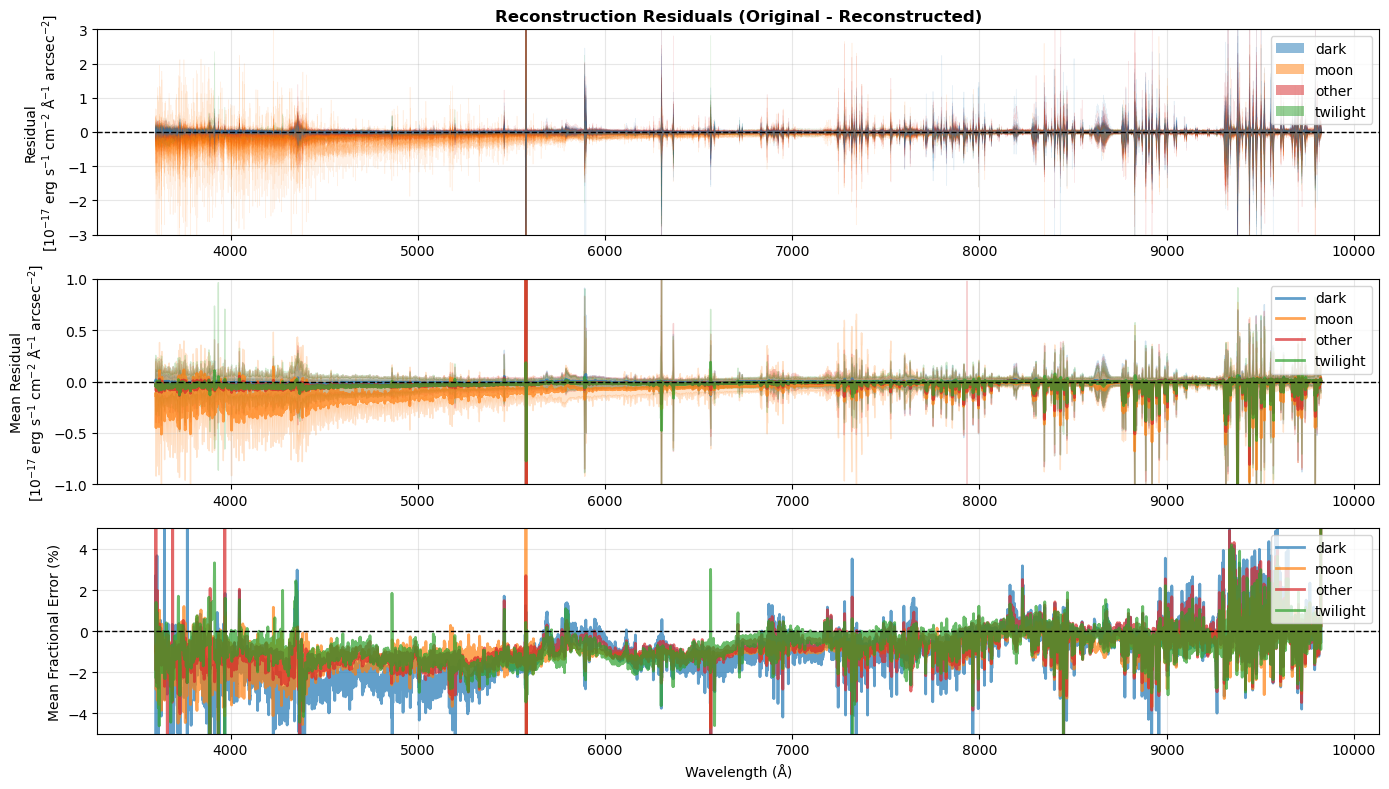

In [8]:
def plot_reconstruction_residuals(wavelength, flux, decoded, sky_conditions, n_samples=100, figsize=(14, 8)):
    """Plot reconstruction residuals to show where the VAE struggles."""
    residuals = flux - decoded
    
    sky_color_scheme = {
        'dark': '#1f77b4',
        'moon': '#ff7f0e',
        'twilight': '#2ca02c',
        'other': '#d62728'
    }
    
    fig, axes = plt.subplots(3, 1, figsize=figsize)
    
    # Panel 1: Individual residuals
    indices = np.random.choice(len(flux), size=min(n_samples, len(flux)), replace=False)
    for idx in indices:
        color = sky_color_scheme.get(sky_conditions[idx], '#7f7f7f')
        axes[0].plot(wavelength, residuals[idx], alpha=0.1, color=color, linewidth=0.5)
    
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=sky_color_scheme[cat], alpha=0.5, label=cat) 
                      for cat in np.unique(sky_conditions)]
    axes[0].set_ylim(-3, 3)
    axes[0].legend(handles=legend_elements, loc='upper right')
    axes[0].axhline(0, color='black', linestyle='--', linewidth=1)
    axes[0].set_ylabel('Residual\n[$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$ arcsec$^{-2}$]')
    axes[0].set_title('Reconstruction Residuals (Original - Reconstructed)', fontweight='bold')
    axes[0].grid(alpha=0.3)
    
    # Panel 2: Mean and std by condition
    for condition in np.unique(sky_conditions):
        mask = sky_conditions == condition
        mean_residual = np.mean(residuals[mask], axis=0)
        std_residual = np.std(residuals[mask], axis=0)
        
        color = sky_color_scheme.get(condition, '#7f7f7f')
        axes[1].plot(wavelength, mean_residual, label=condition, alpha=0.7, color=color, linewidth=2)
        axes[1].fill_between(wavelength, mean_residual - std_residual, mean_residual + std_residual,
                             alpha=0.2, color=color)
    axes[1].set_ylim(-1, 1)
    axes[1].axhline(0, color='black', linestyle='--', linewidth=1)
    axes[1].set_ylabel('Mean Residual\n[$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$ arcsec$^{-2}$]')
    axes[1].legend(loc='upper right')
    axes[1].grid(alpha=0.3)
    
    # Panel 3: Fractional error
    fractional_error = residuals / (flux + 1e-10)
    for condition in np.unique(sky_conditions):
        mask = sky_conditions == condition
        mean_frac_error = np.mean(fractional_error[mask], axis=0)
        color = sky_color_scheme.get(condition, '#7f7f7f')
        axes[2].plot(wavelength, mean_frac_error * 100, label=condition, alpha=0.7, color=color, linewidth=2)
    
    axes[2].set_ylim(-5, 5)
    axes[2].axhline(0, color='black', linestyle='--', linewidth=1)
    axes[2].set_xlabel('Wavelength (Å)')
    axes[2].set_ylabel('Mean Fractional Error (%)')
    axes[2].legend(loc='upper right')
    axes[2].grid(alpha=0.3)
    
    plt.tight_layout()
    return fig

fig = plot_reconstruction_residuals(wavelength, flux, decoded, sky_conditions, n_samples=200)
plt.show()

## Visualization 4: Latent Space Interpolation

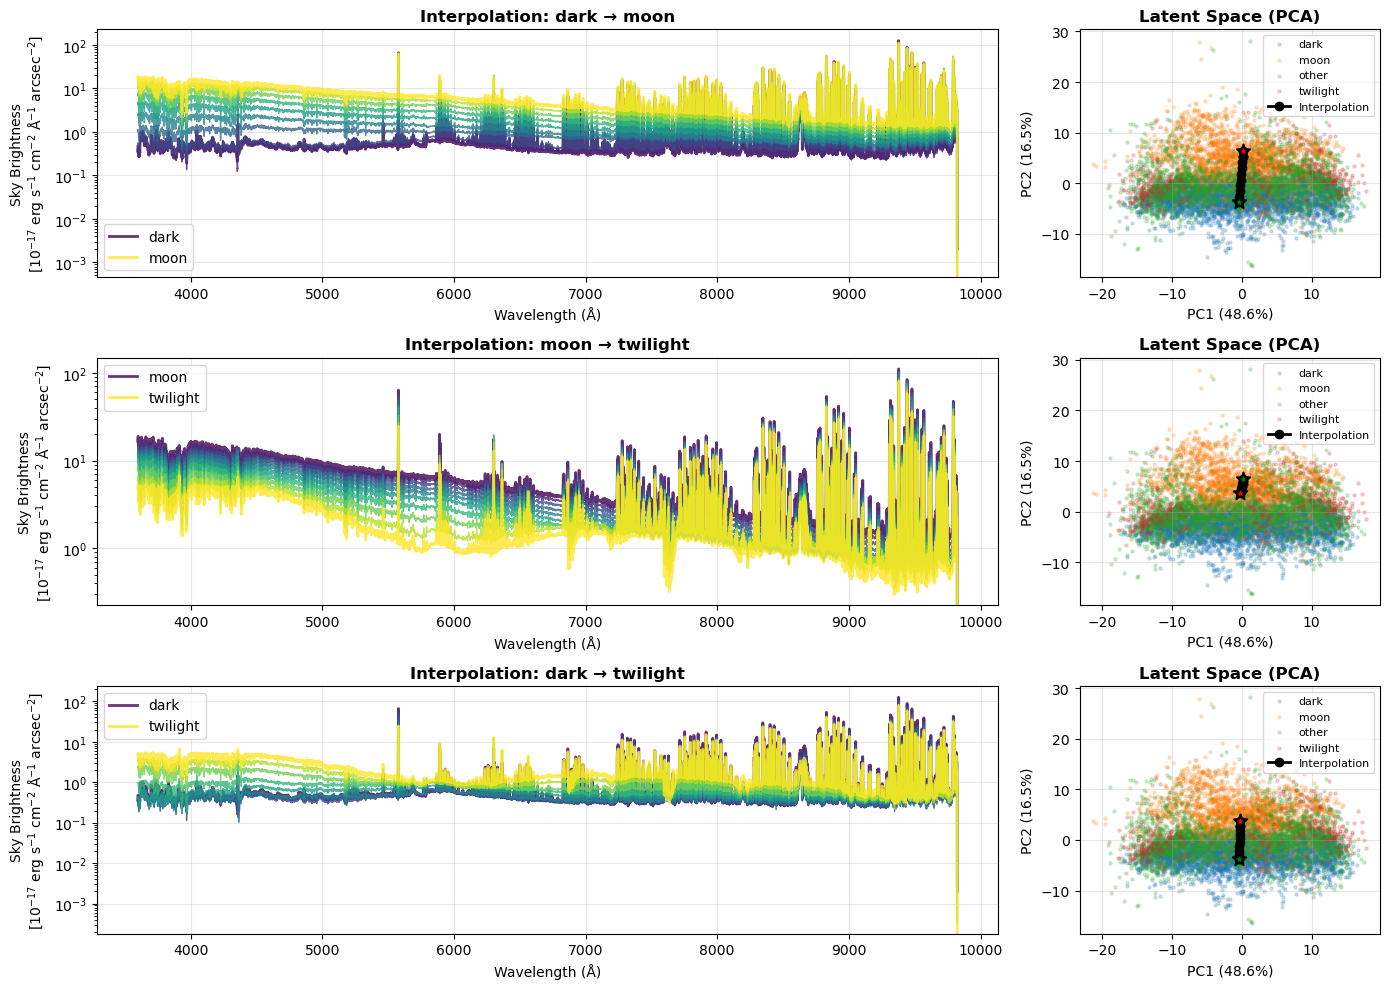

In [9]:
def plot_latent_interpolation(vae, latents, sky_conditions, wavelength, n_steps=7, figsize=(14, 10)):
    """Interpolate between different sky conditions in latent space."""
    # Find representative examples
    representatives = {}
    for condition in ['dark', 'moon', 'twilight']:
        if condition in sky_conditions:
            mask = sky_conditions == condition
            if np.sum(mask) > 0:
                cond_latents = latents[mask]
                mean_latent = np.mean(cond_latents, axis=0)
                distances = np.sum((cond_latents - mean_latent)**2, axis=1)
                closest_idx = np.argmin(distances)
                representatives[condition] = cond_latents[closest_idx]
    
    interpolations = [
        ('dark', 'moon'),
        ('moon', 'twilight'),
        ('dark', 'twilight')
    ]
    
    n_interp = len([i for i in interpolations if i[0] in representatives and i[1] in representatives])
    fig, axes = plt.subplots(n_interp, 2, figsize=figsize, gridspec_kw={'width_ratios': [3, 1]})
    
    if n_interp == 1:
        axes = axes.reshape(1, -1)
    
    plot_idx = 0
    for start_cond, end_cond in interpolations:
        if start_cond not in representatives or end_cond not in representatives:
            continue
            
        start_latent = representatives[start_cond]
        end_latent = representatives[end_cond]
        
        alphas = np.linspace(0, 1, n_steps)
        interpolated_latents = np.array([
            (1 - alpha) * start_latent + alpha * end_latent 
            for alpha in alphas
        ])
        
        decoded_spectra = jax.vmap(vae.decode)(interpolated_latents)
        
        cmap = plt.cm.viridis
        
        # Decoded spectra
        for i, (alpha, spectrum) in enumerate(zip(alphas, decoded_spectra)):
            color = cmap(alpha)
            label = f'{start_cond}' if i == 0 else (f'{end_cond}' if i == n_steps-1 else None)
            axes[plot_idx, 0].plot(wavelength, spectrum, color=color, alpha=0.8, 
                                  linewidth=2 if i in [0, n_steps-1] else 1, label=label)
        
        axes[plot_idx, 0].set_yscale('log')
        axes[plot_idx, 0].set_xlabel('Wavelength (Å)')
        axes[plot_idx, 0].set_ylabel('Sky Brightness\n[$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$ arcsec$^{-2}$]')
        axes[plot_idx, 0].set_title(f'Interpolation: {start_cond} → {end_cond}', fontweight='bold')
        axes[plot_idx, 0].legend()
        axes[plot_idx, 0].grid(alpha=0.3)
        
        # Latent space PCA
        pca = PCA(n_components=min(3, latents.shape[1]))
        all_latents_pca = pca.fit_transform(latents)
        interp_pca = pca.transform(interpolated_latents)
        
        for condition in np.unique(sky_conditions):
            mask = sky_conditions == condition
            axes[plot_idx, 1].scatter(all_latents_pca[mask, 0], all_latents_pca[mask, 1],
                                     alpha=0.2, s=5, label=condition)
        
        axes[plot_idx, 1].plot(interp_pca[:, 0], interp_pca[:, 1], 'k-', linewidth=2, 
                              marker='o', markersize=6, label='Interpolation')
        axes[plot_idx, 1].scatter(interp_pca[0, 0], interp_pca[0, 1], c='green', s=100, 
                                 marker='*', edgecolors='black', linewidths=1.5, zorder=10)
        axes[plot_idx, 1].scatter(interp_pca[-1, 0], interp_pca[-1, 1], c='red', s=100,
                                 marker='*', edgecolors='black', linewidths=1.5, zorder=10)
        
        axes[plot_idx, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
        axes[plot_idx, 1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
        axes[plot_idx, 1].set_title('Latent Space (PCA)', fontweight='bold')
        axes[plot_idx, 1].legend(fontsize=8)
        axes[plot_idx, 1].grid(alpha=0.3)
        
        plot_idx += 1
    
    plt.tight_layout()
    return fig

fig = plot_latent_interpolation(vae, latents, sky_conditions, wavelength, n_steps=10)
plt.show()

## Visualization 5: Latent-Physical Parameter Correlations

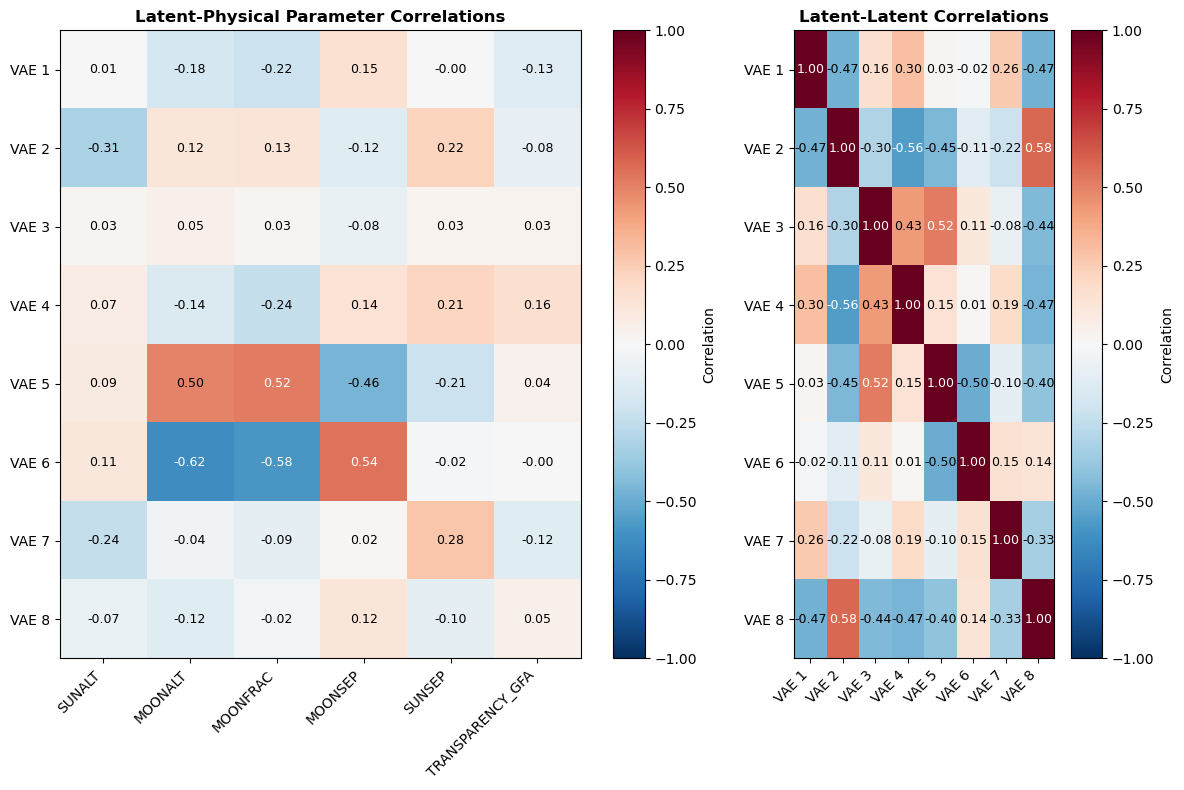

In [10]:
def plot_latent_correlations(latents, metadata, figsize=(12, 8)):
    """Plot correlation between latent dimensions and physical parameters."""
    phys_params = ['SUNALT', 'MOONALT', 'MOONFRAC', 'MOONSEP', 'SUNSEP', 'TRANSPARENCY_GFA']
    available_params = [p for p in phys_params if p in metadata.columns]
    
    latent_dim = latents.shape[1]
    combined_data = np.column_stack([latents, metadata[available_params].values])
    
    latent_labels = [f'VAE {i+1}' for i in range(latent_dim)]
    corr_matrix = np.corrcoef(combined_data.T)
    latent_phys_corr = corr_matrix[:latent_dim, latent_dim:]
    
    fig, axes = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': [2, 1]})
    
    # Latent-Physical correlations
    im1 = axes[0].imshow(latent_phys_corr, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
    axes[0].set_xticks(np.arange(len(available_params)))
    axes[0].set_yticks(np.arange(latent_dim))
    axes[0].set_xticklabels(available_params, rotation=45, ha='right')
    axes[0].set_yticklabels(latent_labels)
    axes[0].set_title('Latent-Physical Parameter Correlations', fontweight='bold')
    
    for i in range(latent_dim):
        for j in range(len(available_params)):
            text = axes[0].text(j, i, f'{latent_phys_corr[i, j]:.2f}',
                               ha="center", va="center", 
                               color="black" if abs(latent_phys_corr[i, j]) < 0.5 else "white", fontsize=9)
    plt.colorbar(im1, ax=axes[0], label='Correlation')
    
    # Latent-Latent correlations
    latent_corr = corr_matrix[:latent_dim, :latent_dim]
    im2 = axes[1].imshow(latent_corr, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
    axes[1].set_xticks(np.arange(latent_dim))
    axes[1].set_yticks(np.arange(latent_dim))
    axes[1].set_xticklabels(latent_labels, rotation=45, ha='right')
    axes[1].set_yticklabels(latent_labels)
    axes[1].set_title('Latent-Latent Correlations', fontweight='bold')
    
    for i in range(latent_dim):
        for j in range(latent_dim):
            text = axes[1].text(j, i, f'{latent_corr[i, j]:.2f}',
                               ha="center", va="center",
                               color="black" if abs(latent_corr[i, j]) < 0.5 else "white", fontsize=9)
    plt.colorbar(im2, ax=axes[1], label='Correlation')
    
    plt.tight_layout()
    return fig

fig = plot_latent_correlations(latents, metadata)
plt.show()

## Summary

This notebook demonstrated:

1. ✅ Loading a pre-trained VAE model using `load_builtin()`
2. ✅ Encoding spectra to latent space and decoding back
3. ✅ Classifying sky conditions from observational metadata
4. ✅ Visualizing reconstruction quality
5. ✅ Exploring latent space structure with corner plots
6. ✅ Analyzing reconstruction errors by wavelength and sky condition
7. ✅ Interpolating between sky conditions in latent space
8. ✅ Correlating latent dimensions with physical parameters

### Key Findings

- The VAE successfully compresses 7781-D spectra into 8-D latent space
- Reconstruction quality varies by sky condition and wavelength
- Latent dimensions show meaningful correlations with physical parameters
- Smooth interpolation in latent space generates realistic intermediate spectra